In [1]:
import random
import numpy as np
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt

In [ ]:
# Qvals are {state: {action: Q-value}}

In [2]:
class Agent:
    def __init__(self, init_position = None):
        """
        Initialize an agent with a starting position and possible action set.
        
        Args:
            init_position (tuple): The (x, y) starting coordinates.
            actions (list): List of possible actions (e.g., ['stay', 'up','down','left','right']).
        """
        self.position = init_position  # Agent's (x, y) position on the grid.
        self.actions = ['stay', 'up', 'down', 'left', 'right']
        # Q-table: maps global state (all agents' positions + active reward target) to action values.
        self.q_table = {}

    def get_state_key(self, global_state):
        """
        Return a hashable key representing the global state.
        The global_state is expected to be a tuple: (tuple_of_agent_positions, active_reward_target)
        """
        return global_state

    def choose_action(self, state_key, epsilon=0.1):
        """
        Choose an action using an epsilon-greedy policy based on the Q-table.
        
        Args:
            state_key: The key representing the current global state.
            epsilon (float): Exploration rate.
            
        Returns:
            action (str): Chosen action.
        """
        if state_key not in self.q_table:
            self.q_table[state_key] = {action: 0.0 for action in self.actions}
        if random.random() < epsilon:
            return random.choice(self.actions)
        else:
            action_values = self.q_table[state_key]
            return max(action_values, key=action_values.get)

    def update_q_value(self, state_key, action, reward, next_state_key, alpha=0.1, gamma=0.99):
        """
        Update Q-value for the given state and action using the Q-learning update rule.
        
        Args:
            state_key: Current global state key.
            action (str): Action taken.
            reward (float): Immediate reward received.
            next_state_key: Next global state key.
            alpha (float): Learning rate.
            gamma (float): Discount factor.
        """
        if state_key not in self.q_table:
            self.q_table[state_key] = {a: 0.0 for a in self.actions}
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = {a: 0.0 for a in self.actions}
        best_next_value = max(self.q_table[next_state_key].values())
        td_target = reward + gamma * best_next_value
        td_error = td_target - self.q_table[state_key][action]
        self.q_table[state_key][action] += alpha * td_error


In [3]:
class BaseEnvironment:
    def __init__(self, grid_size, agents, target_rewards, together_reward, travel_reward):
        """
        Initialize the environment.
        
        Args:
            grid_size (tuple): (width, height) of the grid.
            n_agents (int): Number of agents in the environment.
            target_rewards (list): List of target rewards for each agent (e.g., [10, 10] for two agents).
            together_reward (float): Bonus reward if agents are at the same position.
            travel_reward (float): Penalty (energy cost) for each move.
        """
        self.grid_size = grid_size
        self.agents = agents # List of Agent instances.
        self.target_rewards = target_rewards
        self.together_reward = together_reward
        self.travel_reward = travel_reward
        
        # Active reward target managed by the environment.
        # It will be a tuple (like ('right','left')) or None if not active.
        self.active_reward_target = None
        self.possibilities = []
        
        # Center of the grid.
        self.center_pos = (grid_size[0] // 2, grid_size[1] // 2)
        
        # Mapping from reward identifiers to board coordinates.
        self.reward_place_to_coord = {
            (): (),
            ('up',): ((grid_size[0] // 2, grid_size[1] - 1),),
            ('right',): ((grid_size[0] - 1, grid_size[1] // 2),),
            ('down',): ((grid_size[0] // 2, 0),),
            ('left',): ((0, grid_size[1] // 2),),
            ('up','right'): ((grid_size[0] // 2, grid_size[1] - 1), (grid_size[0] - 1, grid_size[1] // 2)),
            ('right','down'): ((grid_size[0] - 1, grid_size[1] // 2), (grid_size[0] // 2, 0)),
            ('down','left'): ((grid_size[0] // 2, 0), (0, grid_size[1] // 2)),
            ('up','left'): ((0, grid_size[1] // 2), (grid_size[0] // 2, grid_size[1] - 1)),
            ('up','down'): ((grid_size[0] // 2, grid_size[1] - 1), (grid_size[0] // 2, 0)),
            ('right','left'): ((grid_size[0] - 1, grid_size[1] // 2), (0, grid_size[1] // 2)),
            # Additional mappings can be added as needed.
        }
        
        # For resetting when no rewards are collected over time.
        self.steps_without_reward = 0
        self.no_reward_threshold = 50

    def get_global_state(self):
        """
        Return the combined global state:
            - Tuple of all agent positions.
            - The current active reward target.
        """
        agent_positions = tuple(agent.position for agent in self.agents)
        # Use None if no active reward target.
        return (agent_positions, self.active_reward_target)

    def reset(self):
        """
        Reset agent positions randomly within the grid.
        Also clear the active reward target.
        """
        for agent in self.agents:
            agent.position = (random.randint(0, self.grid_size[0]-1),
                              random.randint(0, self.grid_size[1]-1))
        self.active_reward_target = None
        self.true_reward_target = random.choice(self.possibilities)

    def move_agents(self, actions):
        """
        Update each agent's position based on the given action.
        
        Args:
            actions (list): List of actions (one per agent).
        """
        moves = {
            'stay': (0, 0),
            'up':    (0, -1),
            'down':  (0, 1),
            'left':  (-1, 0),
            'right': (1, 0)
        }
        for idx, action in enumerate(actions):
            agent = self.agents[idx]
            dx, dy = moves.get(action, (0, 0))
            new_x = max(0, min(self.grid_size[0] - 1, agent.position[0] + dx))
            new_y = max(0, min(self.grid_size[1] - 1, agent.position[1] + dy))
            agent.position = (new_x, new_y)

    def step(self, actions):
        """
        Execute one time step in the environment:
          1. Move agents according to their actions.
          2. Check for reward activation (e.g., an agent reaching the center).
          3. Check if agents are at the designated reward positions.
          4. Apply travel penalty and together bonus.
          5. Reset if no reward is collected for too long.
        
        Args:
            actions (list): List of actions, one per agent.
            
        Returns:
            observations (list): Each agent's observed global state.
            rewards (list): Reward for each agent.
        """
        # 1. Move agents.
        self.move_agents(actions)
        # Update global state.
        global_state = self.get_global_state()
        rewards = [0 for _ in self.agents]
        
        # 2. Check for reward activation if none is active.
        self.check_and_activate_rewards()
        
        # 3. Compute rewards based on agent positions and active reward target.
        collected = self.compute_rewards(rewards)
        
        # 4. Add together bonus if all agents are at the same position.
        if len(set(agent.position for agent in self.agents)) == 1:
            rewards = [r + self.together_reward for r in rewards]
        
        # 5. Add travel (energy loss) penalty.
        rewards = [r + self.travel_reward for r in rewards]
        
        # Update no-reward counter.
        if not collected:
            self.steps_without_reward += 1
        else:
            self.steps_without_reward = 0
        
        # 6. If no reward is collected for too long, reset agents and active reward target.
        if self.steps_without_reward > self.no_reward_threshold:
            self.reset()
            self.steps_without_reward = 0
        
        # Return the new global state as observation for all agents.
        new_state = self.get_global_state()
        observations = [new_state for _ in self.agents]
        return observations, rewards, {}

    def check_and_activate_rewards(self):
        """
        Check if any agent is at the center and no reward target is active.
        If so, activate the reward target.
        This method is meant to be overridden by regime-specific environments.
        """
        if self.active_reward_target is None:
            for agent in self.agents:
                if agent.position == self.center_pos:
                    self.active_reward_target = self.true_reward_target
                    break

    def compute_rewards(self, rewards):
        """
        Compute rewards based on agent positions and active reward target.
        Modify the rewards list in place.
        Returns:
            collected (bool): True if the reward has been collected.
        This method is meant to be overridden by regime-specific environments.
        """
        collected = False
        if self.active_reward_target:
            coords = self.reward_place_to_coord.get(self.true_reward_target, ())
            for reward_coord in coords:
                if all(agent.position == reward_coord for agent in self.agents):
                    for i in range(len(rewards)):
                        rewards[i] += self.target_rewards[i]
                    collected = True
                    break
        if collected:
            self.active_reward_target = None
        return collected

class EnvironmentRegime0(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        # Fixed reward target for regime 0.
        self.possibilities = [()]
        self.reset()

    def check_and_activate_rewards(self):
        # In regime 0, we do not need to activate a reward zone.
        pass
        
    def compute_rewards(self, rewards):
        collected = False
        if any(agent.position == self.center_pos for agent in self.agents):
            for i in range(len(rewards)):
                rewards[i] += self.target_rewards[i]
            collected = True
        return collected

class EnvironmentRegime1(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        self.possibilities = [('right', 'left')]
        self.reset()

class EnvironmentRegime2(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        self.possibilities = [('up', 'down')]
        self.reset()

class EnvironmentRegime3(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        self.possibilities = [
            ('up', 'right'),
            ('right', 'down'),
            ('down', 'left'),
            ('up', 'left'),
            ('right', 'left'),
            ('up', 'down')
        ]
        self.reset()

In [4]:
class Trainer:
    def __init__(self, env, num_steps, epsilon_start, epsilon_end):
        """
        Initialize the trainer.
        
        Args:
            env (BaseEnvironment): An instance of a regime-specific environment.
            num_steps (int): Total number of training steps.
            epsilon_start (float): Initial exploration rate.
            epsilon_end (float): Final exploration rate.
        """
        self.env = env
        self.num_steps = num_steps
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end

    def train(self, alpha=0.1, gamma=0.99, verbose=True):
        """
        Run the training loop.
        
        Returns:
            history (dict): Collected reward history per agent.
        """
        history = {i: [] for i in range(len(self.env.agents))}
        state = self.env.get_global_state()
        for step in tqdm(range(self.num_steps), disable=not verbose):
            # Linearly decay epsilon.
            epsilon = ((self.epsilon_end - self.epsilon_start) / self.num_steps) * step + self.epsilon_start
            
            # Each agent chooses an action based on the global state.
            actions = []
            for agent in self.env.agents:
                state_key = agent.get_state_key(state)
                actions.append(agent.choose_action(state_key, epsilon))
            
            # Environment processes the actions.
            observations, rewards, info = self.env.step(actions)
            next_state = observations[0]  # global state (same for all agents)
            
            # Each agent updates its Q-table.
            for i, agent in enumerate(self.env.agents):
                state_key = agent.get_state_key(state)
                next_state_key = agent.get_state_key(next_state)
                agent.update_q_value(state_key, actions[i], rewards[i], next_state_key, alpha, gamma)
                history[i].append(rewards[i])
            
            state = next_state
        return history

In [26]:
# Agents
n_agents = 2
target_rewards = [10] * n_agents  # Reward for each agent when target is met
agents = [Agent() for _ in range(n_agents)] 

# Parameters for the grid and rewards
grid_size = (5, 5)
together_reward = 0      # No bonus if agents are together
travel_reward = -1       # Penalty for movement
num_steps = 1_000_000
epsilon_start = 0.99
epsilon_end = 0.4 # 0.4

# Training parameters
alpha = 0.99 # 0.1 # Learning rate
gamma = 0.5

# List the environments and train sequentially.
environments = [EnvironmentRegime0, EnvironmentRegime1, EnvironmentRegime2, EnvironmentRegime3]
# environments = [EnvironmentRegime3]
rrh = [] # Reward history for each regime
for i, e in enumerate(environments):
    print(f"--- Training in Environment Regime {i} ---")
    # Create one environment per regime.
    env = e(grid_size, agents, target_rewards, together_reward, travel_reward)
    trainer = Trainer(env, num_steps, epsilon_start, epsilon_end)
    reward_history = trainer.train(alpha=alpha, gamma=gamma)
    rrh.append(reward_history)


--- Training in Environment Regime 0 ---


100%|██████████| 1000000/1000000 [00:04<00:00, 223009.69it/s]


--- Training in Environment Regime 1 ---


100%|██████████| 1000000/1000000 [00:04<00:00, 212263.33it/s]


--- Training in Environment Regime 2 ---


100%|██████████| 1000000/1000000 [00:04<00:00, 212196.04it/s]


--- Training in Environment Regime 3 ---


100%|██████████| 1000000/1000000 [00:04<00:00, 209264.33it/s]


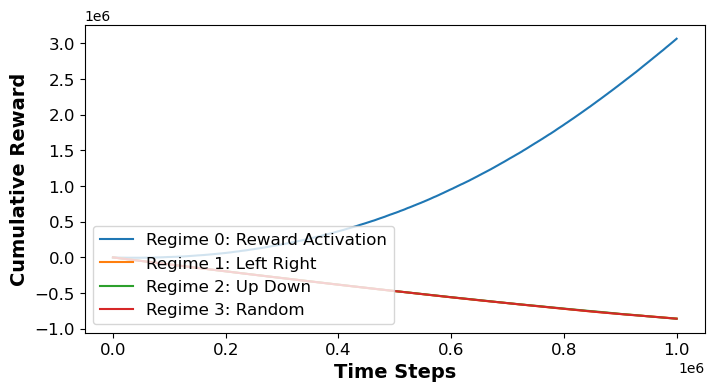

In [27]:
plt.figure(figsize=(8, 4))
regime_names = ['Regime 0: Reward Activation', 'Regime 1: Left Right', 'Regime 2: Up Down', 'Regime 3: Random']
for regime, reward_history in enumerate(rrh):
    rh = np.array(reward_history[0])
    crh = np.cumsum(rh, axis=0)
    plt.plot(crh, label=regime_names[regime])
plt.legend(fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(-5e6, 0.1e6)
plt.legend(loc="lower left", fontsize=12)
plt.show()